# Modeling Workflow Example - Greenplum Database

## Classification of Credit Card Approval
* Reference : [Jarrod Vawdrey's GitHub](https://github.com/jvawdrey/gpdb5-demo/blob/master/docker-jupyter/notebooks/Modeling%20Workflow%20Example%20-%20Greenplum%20Database.ipynb)

## Docker image of Greenplum Database on CentOS with Pivotal Data Science Tool Kits, such as MADlib, PL/R and PL/Python
* https://hub.docker.com/r/hdlee2u/gpdb-analytics/

- CentOS : release 7.4
- Greenplum Database : ver 5.10.2
- MADlib : ver 1.15
- PL/R : 2.3.2
- DataScienceR : 1.0.1
- DataSciencePython : 1.1.1

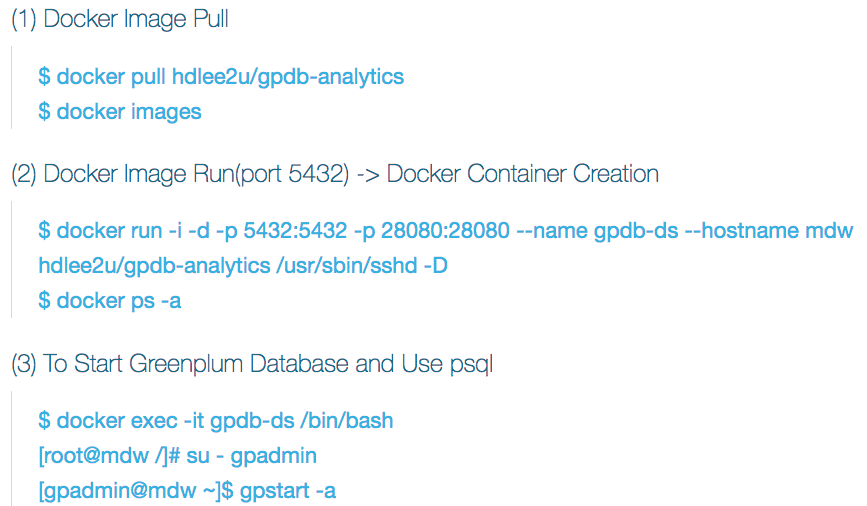

In [1]:
from IPython.display import Image
Image(filename='/Users/ihongdon/Documents/MADlib/classification_demo/docker_pull_run.png')

#### Data Set Information:

This file concerns **credit card applications**. All attribute names and values have been changed to meaningless symbols to protect confidentiality of the data.

This dataset is interesting because there is a good mix of attributes -- continuous, nominal with small numbers of values, and nominal with larger numbers of values. There are also a few missing values.

#### Attribute Information:

> 
A1: b, a. <br />
A2: continuous. <br />
A3: continuous. <br />
A4: u, y, l, t. <br />
A5: g, p, gg. <br />
A6: c, d, cc, i, j, k, m, r, q, w, x, e, aa, ff. <br />
A7: v, h, bb, j, n, z, dd, ff, o. <br />
A8: continuous. <br />
A9: t, f. <br />
A10: t, f. <br />
A11: continuous. <br />
A12: t, f. <br />
A13: g, p, s. <br />
A14: continuous. <br />
A15: continuous. <br />
A16: +,- (class attribute) <br />

## 1. Environment Set-up

### 1-1. Import python common modules

In [2]:
# Common modules
import numpy as np
import pandas as pd
import sklearn
import math
import textwrap as tw
from pandas import DataFrame
from pandas import Series

# For DB Connecton
import psycopg2
from sqlalchemy import create_engine
import sql_magic

# For reproducibility
np.random.seed(2622)

# Directory
import os

/Users/ihongdon/anaconda3/envs/py2.7_tf1.4/lib/python2.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


### 1-2. Directory set-up

In [3]:
# directory where the downloaded data and images are
USER_DOCU_DIR = "/Users/ihongdon/Documents/" # change with your own directory
MADLIB_PROJECT_DIR = "MADlib/classification_demo/"
MADLIB_PROJECT_PATH = os.path.join(USER_DOCU_DIR, MADLIB_PROJECT_DIR)

### 1-3. Visualization Params Setup

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# To draw plots in jupyter notebook
#%matplotlib inline
%pylab inline

from pylab import rcParams
rcParams['figure.figsize'] = 12, 8
rcParams['axes.labelsize'] = 14
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 1000)

# Display
import ipywidgets as widgets
import IPython.display as ipd
from IPython.display import display

# interpret string as markdown
def printmd(string):
    ipd.display(ipd.Markdown(string))

# seaborn style
sns.set(style="darkgrid")

Populating the interactive namespace from numpy and matplotlib


### 1-4. GPDB Connection Setup

In [5]:
# put your own GPDB information
user = 'gpadmin'
password = 'pivotal'
host = 'localhost'
db = 'gpadmin'

connection_string = "postgresql://{user}:{password}@{host}/{db}".\
    format(user=user, 
           password=password, 
           host=host, 
           db=db)
    
conn = psycopg2.connect(connection_string)
cur = conn.cursor()
conn.autocommit = True

In [6]:
# helper function
def query_gpdb(query): 

    cur.execute(query)

    colnames = [desc[0] for desc in cur.description]
    return DataFrame(cur.fetchall(), columns=colnames)

### 1-5. sql_magic
https://github.com/pivotal-legacy/sql_magic

sql_magic is Jupyter magic for writing SQL to interact with Greenplum/PostgreSQL database, Hive and Spark. Query results are saved directly to a Pandas dataframe.

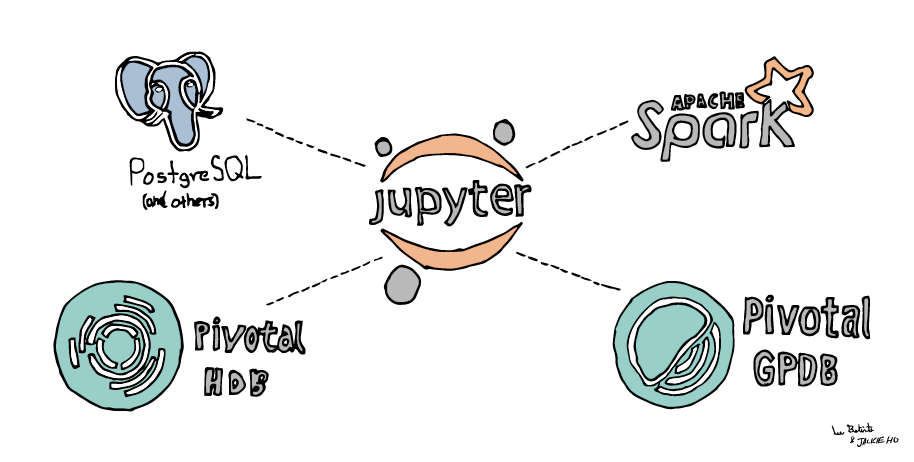

In [7]:
Image(filename=os.path.join(MADLIB_PROJECT_PATH, 'sql_magic_wide.png'))

In [8]:
# sql_magic
postgres_engine = create_engine(connection_string)

# sql_magic package and ext sql_magic to query GPDB
%load_ext sql_magic
#%reload_ext sql_magic

%config SQL.conn_name = 'postgres_engine'

# '%execsql' for sql execution
# '%read_sql' for reading table as a DataFrame format
from IPython.core.magic import (register_line_magic, register_cell_magic, register_line_cell_magic)
@register_cell_magic
def execsql(line, cell):
    _ = postgres_engine.execute(cell)
    return

### 1-4. GPDB, MADlib, PL/x Check

In [9]:
# GPDB version
%read_sql select version();

Query started at 01:05:22 AM KST; Query executed in 0.00 m

,version
0,"PostgreSQL 8.3.23 (Greenplum Database 5.10.2 build commit:b3c02f3acd880e2d676dacea36be015e4a3826d4) on x86_64-pc-linux-gnu, compiled by GCC gcc (GCC) 6.2.0, 64-bit compiled on Aug 10 2018 07:30:09"


In [10]:
# GPDB master, segment node configuration
%read_sql select * from pg_catalog.gp_segment_configuration

Query started at 01:05:22 AM KST; Query executed in 0.00 m

,dbid,content,role,preferred_role,mode,status,port,hostname,address,replication_port
0,1,-1,p,p,s,u,5432,mdw,mdw,None
1,2,0,p,p,s,u,40000,mdw,mdw,None
2,3,1,p,p,s,u,40001,mdw,mdw,None


In [11]:
# MADlib version
%read_sql select madlib.version();

Query started at 01:05:22 AM KST; Query executed in 0.00 m

,version
0,"MADlib version: 1.15, git revision: rel/v1.15, cmake configuration time: Sat Aug 11 00:02:04 UTC 2018, build type: Release, build system: Linux-4.4.0-112-generic, C compiler: gcc 4.8.5, C++ compiler: g++ 4.8.5"


In [12]:
# PL/Languages
%read_sql select * from pg_catalog.pg_language;

Query started at 01:05:23 AM KST; Query executed in 0.00 m

,lanname,lanowner,lanispl,lanpltrusted,lanplcallfoid,laninline,lanvalidator,lanacl
0,internal,10,False,False,0,0,2246,None
1,c,10,False,False,0,0,2247,None
2,sql,10,False,True,0,0,2248,None
3,plpgsql,10,True,True,11910,11911,11912,None
4,plpythonu,10,True,False,17038,17039,0,None
5,plr,10,True,False,19622,0,0,None


## 2. Loading Data

### 2-1. Create external web table

In [13]:
%%execsql
DROP EXTERNAL TABLE IF EXISTS public.credit_application_external;
CREATE EXTERNAL WEB TABLE public.credit_application_external(
    a1 varchar(1), 
    a2 float, 
    a3 float, 
    a4 varchar(1), 
    a5 varchar(2), 
    a6 varchar(2), 
    a7 varchar(2), 
    a8 float, 
    a9 varchar(5), --a9 boolean, 
    a10 varchar(5), --a10 boolean, 
    a11 float, 
    a12 varchar(5), --a12 boolean, 
    a13 varchar(1), 
    a14 float, 
    a15 float, 
    a16 varchar(1)
) LOCATION('http://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.data')
FORMAT 'CSV'
(NULL AS '?');

### 2-2. Impute mean or most freq occuring value for null

In [14]:
%%execsql
DROP TABLE IF EXISTS credit_application_data;
CREATE TABLE credit_application_data AS
    SELECT row_number() OVER() AS _id, 
        coalesce(a1, 'b') AS a1, 
        coalesce(a2, avg(a2) OVER()) AS a2, 
        coalesce(a3, avg(a3) OVER()) AS a3, 
        coalesce(a4, 'u') AS a4, 
        coalesce(a5, 'g') AS a5, 
        coalesce(a6, 'c') AS a6, 
        coalesce(a7, 'v') AS a7, 
        coalesce(a8, avg(a8) OVER()) AS a8, 
        coalesce(a9, 't') AS a9, -- coalesce(a9, 'True') AS a9
        coalesce(a10, 'f') AS a10, -- coalesce(a10, 'False') AS a10
        coalesce(a11, 0) AS a11, 
        coalesce(a12, 'f') AS a12, -- coalesce(a12, 'False') AS a12
        coalesce(a13, 'g') AS a13, 
        coalesce(a14, avg(a14) OVER()) AS a14, 
        coalesce(a15, avg(a15) OVER()) AS a15, 
        CASE WHEN a16 = '+' THEN 1 ELSE 0 END AS a16
    FROM credit_application_external
    DISTRIBUTED RANDOMLY;

In [15]:
%read_sql SELECT * FROM credit_application_data LIMIT 5;

Query started at 01:05:23 AM KST; Query executed in 0.00 m

,_id,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16
0,2,a,58.67,4.460,u,g,q,h,3.040,t,t,6.0,f,g,43.0,560.0,1
1,4,b,27.83,1.540,u,g,w,v,3.750,t,t,5.0,t,g,100.0,3.0,1
2,6,b,32.08,4.000,u,g,m,v,2.500,t,f,0.0,t,g,360.0,0.0,1
3,8,a,22.92,11.585,u,g,cc,v,0.040,t,f,0.0,f,g,80.0,1349.0,1
4,10,b,42.50,4.915,y,p,w,v,3.165,t,f,0.0,t,g,52.0,1442.0,1


## 3. Exploratory Data Analysis

### 3-1. Data Audit by Summary Statistics
http://madlib.apache.org/docs/latest/group__grp__summary.html

In [16]:
%%execsql
DROP TABLE IF EXISTS public.credit_application_data_summary;
SELECT * FROM madlib.summary(
    'credit_application_data' -- Source table
    , 'credit_application_data_summary' -- Output table
)

In [17]:
%read_sql SELECT * FROM credit_application_data_summary;

Query started at 01:05:24 AM KST; Query executed in 0.00 m

,group_by,group_by_value,target_column,column_number,data_type,row_count,distinct_values,missing_values,blank_values,fraction_missing,fraction_blank,positive_values,negative_values,zero_values,mean,variance,confidence_interval,min,max,first_quartile,median,third_quartile,most_frequent_values,mfv_frequencies
0,None,None,_id,1,int8,690,690,0,NaN,0.0,NaN,690.0,0.0,0.0,345.500000,3.973250e+04,"[330.626798148, 360.373201852]",1.00,690.00,173.250,345.500,517.7500,"[2, 4, 6, 8, 10, 12, 14, 16, 18, 20]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
1,None,None,a1,2,varchar,690,2,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,None,1.00,1.00,NaN,NaN,NaN,"[b, b, a, a]","[480, 480, 210, 210]"
2,None,None,a2,3,float8,690,350,0,NaN,0.0,NaN,690.0,0.0,0.0,31.568171,1.405001e+02,"[30.6837281819, 32.452614001]",13.75,80.25,22.670,28.625,37.7075,"[31.5681710914455, 31.5681710914455, 22.67, 22.67, 20.42, 19.17, 23.58, 20.67, 23.25, 33.17]","[12, 12, 9, 9, 7, 6, 6, 6, 5, 5]"
3,None,None,a3,4,float8,690,215,0,NaN,0.0,NaN,671.0,0.0,19.0,4.758725,2.478211e+01,"[4.38727438315, 5.13017489221]",0.00,28.00,1.000,2.750,7.2075,"[1.5, 1.5, 3, 2.5, 0, 3, 0, 2.5, 0.75, 1.25]","[21, 21, 19, 19, 19, 19, 19, 19, 16, 16]"
4,None,None,a4,5,varchar,690,3,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,None,1.00,1.00,NaN,NaN,NaN,"[u, u, y, y, l]","[525, 525, 163, 163, 2]"
5,None,None,a5,6,varchar,690,3,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,None,1.00,2.00,NaN,NaN,NaN,"[g, g, p, p, gg]","[525, 525, 163, 163, 2]"
6,None,None,a6,7,varchar,690,14,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,None,1.00,2.00,NaN,NaN,NaN,"[c, c, q, q, w, w, i, i, aa, aa]","[146, 146, 78, 78, 64, 64, 59, 59, 54, 54]"
7,None,None,a7,8,varchar,690,9,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,None,1.00,2.00,NaN,NaN,NaN,"[v, v, h, h, bb, bb, ff, ff, j, z]","[408, 408, 138, 138, 59, 59, 57, 57, 8, 8]"
8,None,None,a8,9,float8,690,132,0,NaN,0.0,NaN,620.0,0.0,70.0,2.223406,1.119915e+01,"[1.97370260799, 2.47310898622]",0.00,28.50,0.165,1.000,2.6250,"[0, 0, 0.25, 0.25, 0.04, 0.04, 1, 1, 0.125, 0.125]","[70, 70, 35, 35, 33, 33, 31, 31, 30, 30]"
9,None,None,a9,10,varchar,690,2,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,None,1.00,1.00,NaN,NaN,NaN,"[t, t, f, f]","[361, 361, 329, 329]"


### 3-2. Bar Plot for Categorical Columns 

-----
 **Select Column:**

A Jupyter Widget

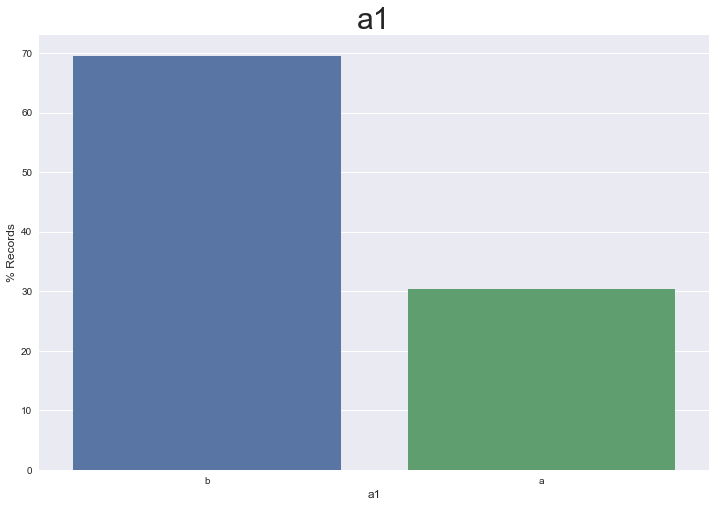

In [18]:
catColumns = ['a1','a4','a5','a6','a7','a9','a10','a12','a13','a16']

def bar_plot(data,title,x,xLabel,y,yLabel,color=None,xAxisRotation=90):

    # Bar plot
    pylab.rcParams['figure.figsize'] = (12, 8)
    seq_col_brew = sns.color_palette("Blues_r", 1)
    sns.color_palette(seq_col_brew)
    if color != None:
        plt = sns.barplot(x=x, y=y, data=data, color=color)
    else:
        plt = sns.barplot(x=x, y=y, data=data)
        
    # titles
    plt.set_title(title,fontsize=30)
    plt.set_xlabel(xLabel,fontsize=12)
    plt.set_ylabel(yLabel,fontsize=12)
    
    # rotate x axis labels
    for item in plt.get_xticklabels():
        item.set_rotation(xAxisRotation)

    # remove scientific notation
    plt.ticklabel_format(style='plain', axis='y')


def get_cat_data_frame(col):
    query = """
        SELECT *
              ,round((record_count * 100.0) / sum(record_count) OVER(),2) AS perc_records
        FROM (
            SELECT {} AS col
                  ,count(*) AS record_count
            FROM public.credit_application_data
            GROUP BY 1
        ) foo
        ORDER BY perc_records DESC
    """.format(col)
    cur.execute(query)

    colnames = [desc[0] for desc in cur.description]
    return pd.DataFrame(cur.fetchall(), columns=colnames)
    
def on_cat_selection(res):
    if res['type'] == 'change' and res['name'] == 'value':
        ipd.clear_output()
        printmd("-----\n **Select Column:**")
        ipd.display(catDropdown)
        df = get_cat_data_frame(res['new'])
        bar_plot(df,res['new'],"col",res['new'],"perc_records","% Records", None, 0)
    
catDropdown = widgets.Dropdown(
    options=catColumns,
    value=catColumns[0],
    description='Column:',
    disabled=False,
)

catDropdown.observe(on_cat_selection)
printmd("-----\n **Select Column:**")
ipd.display(catDropdown)
df = get_cat_data_frame(catColumns[0])
bar_plot(df,catColumns[0],"col",catColumns[0],"perc_records","% Records", None, 0)

### 3-3. Histogram for Continuous Columns

-----


A Jupyter Widget

-----


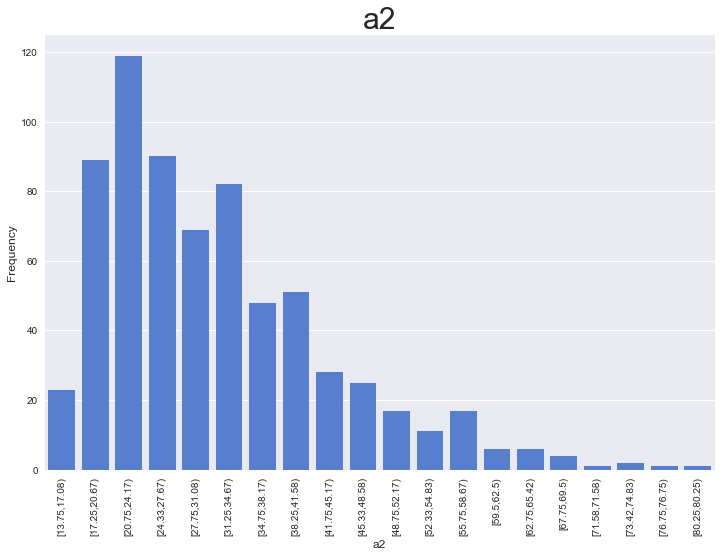

In [19]:
contColumns = ['a2','a3','a8','a11','a14','a15']
sliderValue = 20
colName = contColumns[0]

def get_cont_data_frame(col, buckets):
    query = """
        WITH aggs AS (
            SELECT min({c}) AS min,
                   max({c}) AS max
              FROM public.credit_application_data
        )
        SELECT width_bucket({c}, min, max, {b}-1) AS bucket,
               ('[' || min({c}) || ',' || max({c}) || ')')::text as range,
               count(*) as freq
        FROM public.credit_application_data, aggs
        GROUP BY bucket
        ORDER BY bucket
    """.format(c=col, b=buckets)
    cur.execute(query)

    colnames = [desc[0] for desc in cur.description]
    return pd.DataFrame(cur.fetchall(), columns=colnames)
    
def graph_reset():
    ipd.clear_output()
    printmd("-----\n")
    ipd.display(widgets.HBox((contDropdown,bucketsSlider)))
    printmd("-----\n")
    df = get_cont_data_frame(colName,sliderValue)
    bar_plot(df,colName,"range",colName,"freq","Frequency", "#4378E2")    
    
def on_cont_selection(res):
    global colName
    if res['type'] == 'change' and res['name'] == 'value':
        colName = res['new']
        graph_reset()
        
def on_slider_selection(res):
    global sliderValue
    if res['new'] == {} and res['old']:
        sliderValue = res['old']['value']
        graph_reset()
    
# Look at log transforms
#colsAddLogs = contColumns + ["log({} + 1)".format(c) for c in contColumns]
colsAddLogs = contColumns

contDropdown = widgets.Dropdown(
    options=colsAddLogs,
    value=colsAddLogs[0],
    description='Column:',
    disabled=False,
)

bucketsSlider = widgets.IntSlider(
    value=sliderValue,
    min=5,
    max=50,
    step=1,
    description='# Buckets:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

contDropdown.observe(on_cont_selection)
bucketsSlider.observe(on_slider_selection)

graph_reset()

* a15 large number of outliers - consider correcting
* Consider variable transformation if test non-tree based algorithm
* Histogram values are being calculated in the database - minimal data movement back to client

## 4. Feature Engineering 

### 4-1. Continuous Features (separated out in case feature transformations are required)

In [20]:
query = """
    DROP TABLE IF EXISTS model_inputs_cont;
    CREATE TABLE model_inputs_cont AS
    SELECT _id, 
        a16 AS approval, 
        a2, 
        a3, 
        a8, 
        a11, 
        a14, 
        a15
    FROM credit_application_data
    DISTRIBUTED BY (_id);
    
    SELECT * FROM model_inputs_cont LIMIT 0;
"""
cur.execute(query)

In [21]:
contFeatureNames = [desc[0] for desc in cur.description]
contFeatureNames.remove('_id')
contFeatureNames.remove('approval')
contFeatureNames

['a2', 'a3', 'a8', 'a11', 'a14', 'a15']

In [22]:
%read_sql SELECT * FROM model_inputs_cont LIMIT 5;

Query started at 01:05:25 AM KST; Query executed in 0.00 m

,_id,approval,a2,a3,a8,a11,a14,a15
0,1,1,30.83,0.000,1.25,1.0,202.0,0.0
1,3,1,24.50,0.500,1.50,0.0,280.0,824.0
2,5,1,20.17,5.625,1.71,0.0,120.0,0.0
3,7,1,33.17,1.040,6.50,0.0,164.0,31285.0
4,9,1,54.42,0.500,3.96,0.0,180.0,314.0


### 4-2. One Hot Encoding for Categorical Features 
https://madlib.apache.org/docs/latest/group__grp__encode__categorical.html

In [23]:
# encode categorical features
query = """
    DROP TABLE IF EXISTS model_inputs_cat;
    SELECT madlib.encode_categorical_variables(
        'credit_application_data', -- source table
        'model_inputs_cat', -- output table
        'a1, a4, a5, a6, a7, a9, a10, a12, a13', -- categorical columns
        NULL, -- categorical columns to exclude
        '_id', -- index column
        NULL, -- Top values
        'a1=b, a4=y, a5=p, a6=x, a7=z, a9=f, a10=f, a12=f, a13=s' -- value to drop for dummy encoding
    );
"""
cur.execute(query)   

query = """
    ALTER TABLE public.model_inputs_cat RENAME COLUMN "a9_t" TO a9_true;
    ALTER TABLE public.model_inputs_cat RENAME COLUMN "a10_t" TO a10_true;
    ALTER TABLE public.model_inputs_cat RENAME COLUMN "a12_t" TO a12_true;
"""
cur.execute(query)

query = """
    SELECT * FROM model_inputs_cat LIMIT 0;
"""    
cur.execute(query)

In [24]:
%read_sql SELECT * FROM model_inputs_cat LIMIT 5;

Query started at 01:05:25 AM KST; Query executed in 0.00 m

,_id,a1_a,a4_l,a4_u,a5_g,a5_gg,a6_aa,a6_c,a6_cc,a6_d,a6_e,a6_ff,a6_i,a6_j,a6_k,a6_m,a6_q,a6_r,a6_w,a7_bb,a7_dd,a7_ff,a7_h,a7_j,a7_n,a7_o,a7_v,a9_true,a10_true,a12_true,a13_g,a13_p
0,126,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,1,0
1,128,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0
2,130,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0
3,132,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0
4,134,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0


In [25]:
colnames = [desc[0] for desc in cur.description]
colnames.remove('_id')
catFeatureNames = colnames
featureNames = contFeatureNames + catFeatureNames
print featureNames

['a2', 'a3', 'a8', 'a11', 'a14', 'a15', 'a1_a', 'a4_l', 'a4_u', 'a5_g', 'a5_gg', 'a6_aa', 'a6_c', 'a6_cc', 'a6_d', 'a6_e', 'a6_ff', 'a6_i', 'a6_j', 'a6_k', 'a6_m', 'a6_q', 'a6_r', 'a6_w', 'a7_bb', 'a7_dd', 'a7_ff', 'a7_h', 'a7_j', 'a7_n', 'a7_o', 'a7_v', 'a9_true', 'a10_true', 'a12_true', 'a13_g', 'a13_p']


### 4-3. Combining categorical and continuous variables

In [26]:
%%execsql
DROP TABLE IF EXISTS model_inputs;
CREATE TABLE model_inputs AS
SELECT *
    FROM model_inputs_cat
    JOIN model_inputs_cont
    USING (_id);

In [27]:
%read_sql SELECT * FROM model_inputs LIMIT 5;

Query started at 01:05:26 AM KST; Query executed in 0.00 m

,_id,a1_a,a4_l,a4_u,a5_g,a5_gg,a6_aa,a6_c,a6_cc,a6_d,a6_e,a6_ff,a6_i,a6_j,a6_k,a6_m,a6_q,a6_r,a6_w,a7_bb,a7_dd,a7_ff,a7_h,a7_j,a7_n,a7_o,a7_v,a9_true,a10_true,a12_true,a13_g,a13_p,approval,a2,a3,a8,a11,a14,a15
0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,0,1,0,1,30.83,0.000,1.25,1.0,202.0,0.0
1,5,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,20.17,5.625,1.71,0.0,120.0,0.0
2,9,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,54.42,0.500,3.96,0.0,180.0,314.0
3,13,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,0,1,38.25,6.000,1.00,0.0,0.0,0.0
4,17,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,1,28.25,0.875,0.96,3.0,396.0,0.0


### 4-4. Plot categorical feature by response

-----
 **Select Column:**

A Jupyter Widget

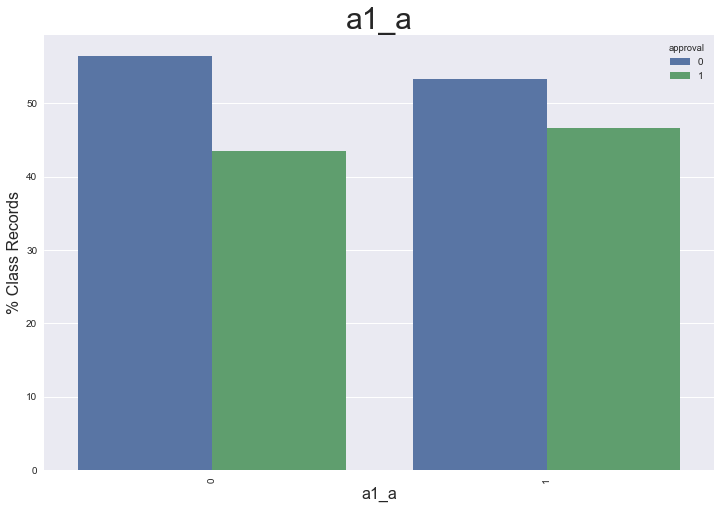

In [28]:
def bar_plot_groupby(data, title, x, xLabel, y, yLabel, groupby, color=None, axisRotation=90):
    
    # Bar plot
    pylab.rcParams['figure.figsize'] = (12, 8)
    seq_col_brew = sns.color_palette("Blues_r", 1)
    sns.color_palette(seq_col_brew)
    
    if color != None:
        plt = sns.barplot(x=x, y=y, data=data, color=color, hue=groupby)
    else:
        plt = sns.barplot(x=x, y=y, data=data, hue=groupby)
        
    # titles
    plt.set_title(title, fontsize=30)
    plt.set_xlabel(xLabel, fontsize=16)
    plt.set_ylabel(yLabel, fontsize=16)
    
    # rotate x axis labels
    for item in plt.get_xticklabels():
        item.set_rotation(axisRotation)

    # remove scientific notation
    plt.ticklabel_format(style='plain', axis='y')

def get_cat_gb_data_frame(col):
    query = """
        SELECT *
              ,round((record_count * 100.0) / sum(record_count) OVER(PARTITION BY col),2) AS perc_records
        FROM (
            SELECT {} AS col
                  , approval
                  , count(*) AS record_count
            FROM model_inputs
            GROUP BY 1,2
        ) foo
        ORDER BY 1,2
    """.format(col)
    cur.execute(query)

    colnames = [desc[0] for desc in cur.description]
    return pd.DataFrame(cur.fetchall(), columns=colnames)
    
def on_cat_gb_selection(res):
    if res['type'] == 'change' and res['name'] == 'value':
        ipd.clear_output()
        printmd("-----\n **Select Column:**")
        ipd.display(catGPDropdown)
        df = get_cat_gb_data_frame(res['new'])
        bar_plot_groupby(df, res['new'],"col", res['new'], "perc_records", "% Class Records", "approval")
    
catGPDropdown = widgets.Dropdown(
    options=catFeatureNames,
    value=catFeatureNames[0],
    description='Column:',
    disabled=False,
)

catGPDropdown.observe(on_cat_gb_selection)
printmd("-----\n **Select Column:**")
ipd.display(catGPDropdown)
df = get_cat_gb_data_frame(catFeatureNames[0])
bar_plot_groupby(df, catFeatureNames[0], "col", catFeatureNames[0], "perc_records", "% Class Records", "approval")

* a9_true appears to be a strong variable due to seperate between classes

### 4-5. Chi-squared testing
https://en.wikipedia.org/wiki/Chi-squared_test <br />
https://madlib.apache.org/docs/latest/group__grp__stats__tests.html

,feature_name,response,statistic,p_value,df,phi,contingency_coef
0,a7_o,approval,0.024633,8.752845e-01,1,0.078475,0.078234
0,a6_c,approval,0.038090,8.452629e-01,1,0.097583,0.097122
0,a7_n,approval,0.049410,8.240931e-01,1,0.111142,0.110462
0,a6_m,approval,0.092817,7.606255e-01,1,0.152330,0.150593
0,a7_bb,approval,0.117396,7.318764e-01,1,0.171315,0.168855
0,a7_j,approval,0.160255,6.889216e-01,1,0.200159,0.196266
0,a7_dd,approval,0.305203,5.806390e-01,1,0.276226,0.266255
0,a1_a,approval,0.577660,4.472309e-01,1,0.380020,0.355234
0,a6_r,approval,0.599873,4.386265e-01,1,0.387257,0.361124
0,a12_true,approval,0.690089,4.061341e-01,1,0.415358,0.383585


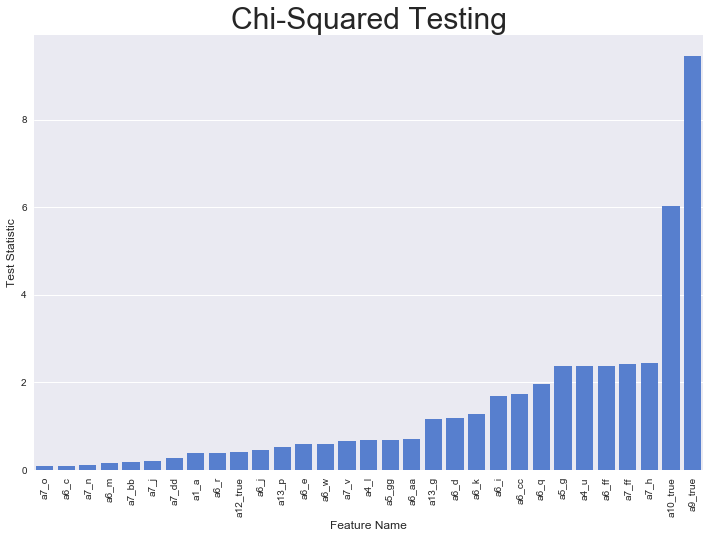

In [29]:
def chi2_gof_test(feature_name, response):
    query = """
        WITH freq AS (
            SELECT {feature_name}
                  ,{response}
                  ,count(*) AS observed
            FROM public.model_inputs
            GROUP BY 1,2
        )
        SELECT '{feature_name}' AS feature_name
              ,'{response}' AS response
              ,(madlib.chi2_gof_test(observed, expected, deg_freedom)).*
        FROM (
            SELECT observed
                  ,sum(observed) OVER (PARTITION BY {feature_name})::DOUBLE PRECISION
                       * sum(observed) OVER (PARTITION BY {response}) AS expected
            FROM freq
        ) l, (
            SELECT (count(distinct {feature_name}) - 1) * (count(distinct {response}) - 1) AS deg_freedom
            FROM freq
        ) r;
    """.format(feature_name=feature_name, response=response)
    cur.execute(query)

    colnames = [desc[0] for desc in cur.description]
    return pd.DataFrame(cur.fetchall(), columns=colnames)

def chi2_gof_test_multi(feature_list, response):
    res = chi2_gof_test(feature_list[0], response)
    for i in range(1,len(feature_list)):
        res = res.append(chi2_gof_test(feature_list[i], response))
        
    return res

chi2_results = chi2_gof_test_multi(catFeatureNames, 'approval')
chi2_results.sort_values('phi', inplace=True)
ipd.display(chi2_results)
bar_plot(chi2_results, "Chi-Squared Testing","feature_name","Feature Name","phi","Test Statistic", "#4378E2")

### 4-6. Correlation Coefficients & Heatmap
https://madlib.apache.org/docs/latest/group__grp__correlation.html

In [30]:
# calc correlations
query = """
    DROP TABLE IF EXISTS public.feature_correlations, public.feature_correlations_summary;
    SELECT madlib.correlation( 
        'public.model_inputs',
        'public.feature_correlations',
        '{}'
    );
    SELECT * 
    FROM public.feature_correlations
    ORDER BY column_position;
""".format(",".join(contFeatureNames))
corr = query_gpdb(query)

corr.drop('column_position', 'columns', inplace=True)
corr.set_index('variable', True, False, True)
corr

,a2,a3,a8,a11,a14,a15
variable,,,,,,
a2,1.000000,NaN,NaN,NaN,NaN,NaN
a3,0.201316,1.000000,NaN,NaN,NaN,NaN
a8,0.392787,0.298902,1.000000,NaN,NaN,NaN
a11,0.185575,0.271207,0.322330,1.000000,NaN,NaN
a14,-0.077161,-0.222346,-0.076389,-0.119809,1.000000,NaN
a15,0.018539,0.123121,0.051345,0.063692,0.065609,1.0


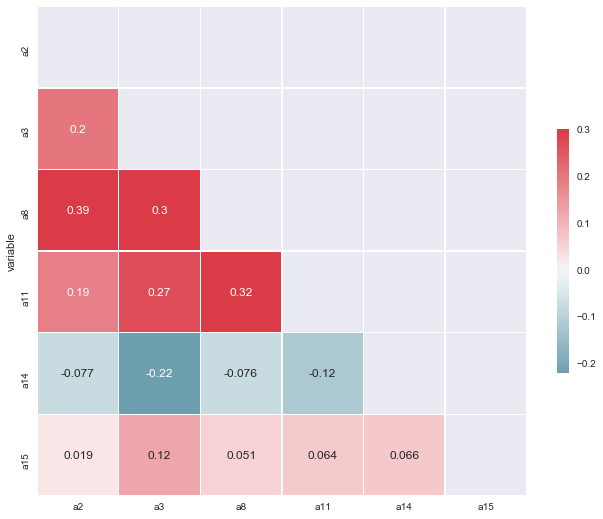

In [31]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

### 4-7. Scatter Plots

In [32]:
def sample_scatter(title, x, xLabel, y, yLabel, sampleSize):
    
    pylab.rcParams['figure.figsize'] = (8, 8)

    # Grab sample
    query = """
        SELECT count(*) AS n
        FROM public.model_inputs;
    """.format(",".join(contFeatureNames))
    cur.execute(query)

    colnames = [desc[0] for desc in cur.description]
    n = pd.DataFrame(cur.fetchall(), columns=colnames)['n'][0]
    limit = math.floor(n * sampleSize)
    
    query = """
        SELECT {} AS col1
              ,{} AS col2
        FROM public.model_inputs
        LIMIT {};
    """.format(x, y, limit)
    cur.execute(query)

    colnames = [desc[0] for desc in cur.description]
    sample = pd.DataFrame(cur.fetchall(), columns=colnames)    
    
    # Generate scatterplot
    if x == y:
        sample
    plt = sns.regplot(x="col1", y="col2", data=sample)
    
    # titles
    plt.set_title("\n".join(tw.wrap(title,50)),fontsize=16)
    plt.set_xlabel(xLabel,fontsize=16)
    plt.set_ylabel(yLabel,fontsize=16)

    # add 1000s commas
    plt.get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda y, p: format(int(y), ',')))
    plt.get_xaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda y, p: format(int(y), ',')))

-----
 **Select Features:**

A Jupyter Widget

A Jupyter Widget

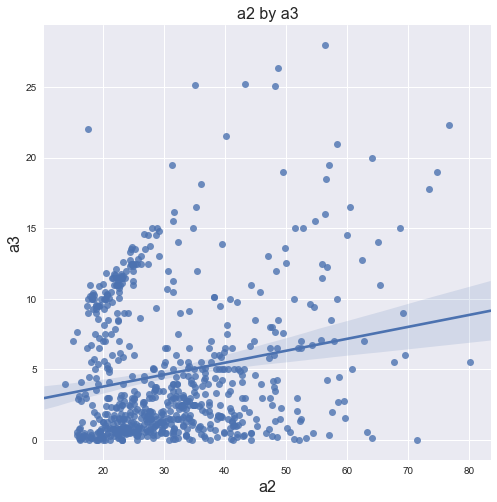

In [33]:
x = contFeatureNames[0]
y = contFeatureNames[1]

def reset():
    ipd.clear_output()
    printmd("-----\n **Select Features:**")
    ipd.display(scatterDropdown1, scatterDropdown2)

    sample_scatter("{} by {}".format(x, y), x, x, y, y, 1)   
    
def os1(res):
    global x
    if res['type'] == 'change' and res['name'] == 'value':
        contFeatureNames.append(x)
        x = res['new']
        contFeatureNames.remove(x)
        reset()

def os2(res):
    global y
    if res['type'] == 'change' and res['name'] == 'value':
        y = res['new']
        reset()
                   
scatterDropdown1 = widgets.Dropdown(
    options=contFeatureNames,
    value=x,
    description='x:',
    disabled=False,
)

scatterDropdown2 = widgets.Dropdown(
    options=contFeatureNames,
    value=y,
    description='y:',
    disabled=False,
)

scatterDropdown1.observe(os1)
scatterDropdown2.observe(os2)

reset()

## 5. Classification Modeling

### 5-1. Training & Validation Sample Split

https://madlib.apache.org/docs/latest/group__grp__train__test__split.html

In [34]:
%%execsql
DROP TABLE IF EXISTS public.model
    , public.model_train
    , public.model_test;
    
SELECT madlib.train_test_split(
    'public.model_inputs' -- source_table
    , 'public.model' -- output_table
    , 0.7 -- train proportion
    , NULL -- test proportion
    , NULL -- grouping columns
    , '*' -- target columns, '*' for all columns
    , FALSE -- with replacement
    , TRUE -- separate output tables
)

In [35]:
%read_sql SELECT * FROM public.model_train LIMIT 5;

Query started at 01:05:29 AM KST; Query executed in 0.00 m

,_id,a1_a,a4_l,a4_u,a5_g,a5_gg,a6_aa,a6_c,a6_cc,a6_d,a6_e,a6_ff,a6_i,a6_j,a6_k,a6_m,a6_q,a6_r,a6_w,a7_bb,a7_dd,a7_ff,a7_h,a7_j,a7_n,a7_o,a7_v,a9_true,a10_true,a12_true,a13_g,a13_p,approval,a2,a3,a8,a11,a14,a15
0,7,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,1,0,1,33.17,1.040,6.500,0.0,164.0,31285.0
1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,54.42,0.500,3.960,0.0,180.0,314.0
2,16,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,1,36.67,4.415,0.250,10.0,320.0,0.0
3,21,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,1,25.00,11.250,2.500,17.0,200.0,1208.0
4,24,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,1,0,1,27.42,14.500,3.085,1.0,120.0,11.0


In [36]:
%read_sql SELECT COUNT(*) AS train_cnt FROM public.model_train;

Query started at 01:05:29 AM KST; Query executed in 0.00 m

,train_cnt
0,483


In [37]:
%read_sql SELECT COUNT(*) AS test_cnt FROM public.model_test;

Query started at 01:05:29 AM KST; Query executed in 0.00 m

,test_cnt
0,207


### 5-2. Random Forest using MADlib

- Random Forest : https://en.wikipedia.org/wiki/Random_forest
- Train model (MADlib) : https://madlib.apache.org/docs/latest/group__grp__random__forest.html

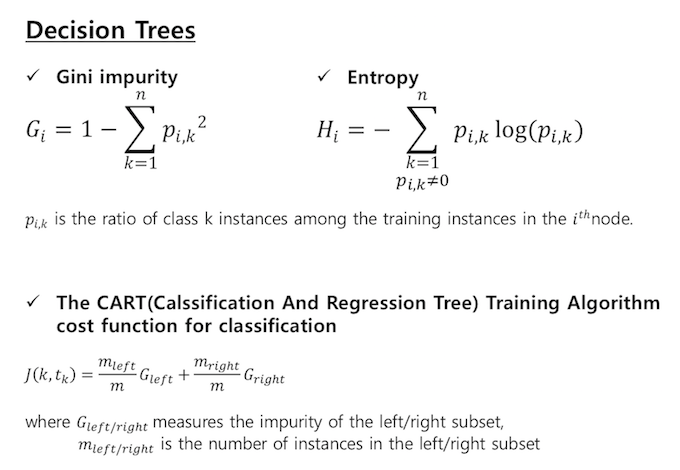

In [38]:
Image(filename=os.path.join(MADLIB_PROJECT_PATH, 'decision_trees.png'))

## Bootstrapping vs. Bagging vs. Random Forest
- Bootstrapping : random sampling with replacement
- Bagging : Bootstrap AGGregatING
- Random Forest : Random sampling by Bagging & **Feature sampling** for **Decision Tree** -> **Decorrelate** trees -> **Reduce  variance** of bagging

* image source: www.researchgate.net


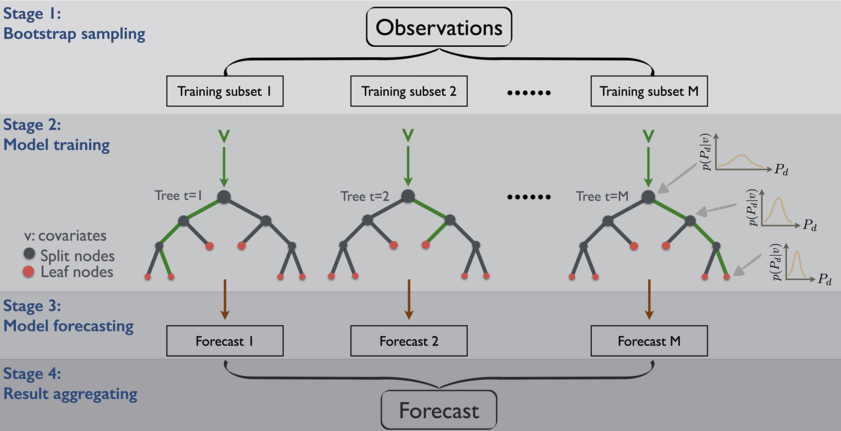

In [39]:
print('* image source: www.researchgate.net')
Image(filename=os.path.join(MADLIB_PROJECT_PATH, 'random_forest.png'))

In [40]:
query = """
DROP TABLE IF EXISTS rf_model_output, rf_model_output_summary, rf_model_output_group;
    
SELECT madlib.forest_train(
    'model_train'       -- source table
    , 'rf_model_output' -- output model table
    , '_id'             -- id column
    , 'approval'        -- response
    , '{}'              -- features
    , null              -- exclude columns
    , null              -- grouping columns
    , 10::integer       -- number of trees
    , 5::integer        -- number of random features
    , TRUE::boolean     -- variable importance
    , 5::integer        -- num_permutations
    , 10::integer       -- max depth
    , 3::integer        -- min split
    , 1::integer        -- min bucket
    , 10::integer       -- number of splits per continuous variable
)
""".format(','.join(featureNames))

cur.execute(query)

#### View the model summary

In [41]:
%%read_sql rf_model_output_summary
SELECT * FROM public.rf_model_output_summary;

Query started at 01:05:32 AM KST; Query executed in 0.00 m

,method,is_classification,source_table,model_table,id_col_name,dependent_varname,independent_varnames,cat_features,con_features,grouping_cols,num_trees,num_random_features,max_tree_depth,min_split,min_bucket,num_splits,verbose,importance,num_permutations,num_all_groups,num_failed_groups,total_rows_processed,total_rows_skipped,dependent_var_levels,dependent_var_type,independent_var_types,null_proxy
0,forest_train,True,model_train,rf_model_output,_id,approval,"a1_a,a4_l,a4_u,a5_g,a5_gg,a6_aa,a6_c,a6_cc,a6_d,a6_e,a6_ff,a6_i,a6_j,a6_k,a6_m,a6_q,a6_r,a6_w,a7_bb,a7_dd,a7_ff,a7_h,a7_j,a7_n,a7_o,a7_v,a9_true,a10_true,a12_true,a13_g,a13_p,a2,a3,a8,a11,a14,a15","a1_a,a4_l,a4_u,a5_g,a5_gg,a6_aa,a6_c,a6_cc,a6_d,a6_e,a6_ff,a6_i,a6_j,a6_k,a6_m,a6_q,a6_r,a6_w,a7_bb,a7_dd,a7_ff,a7_h,a7_j,a7_n,a7_o,a7_v,a9_true,a10_true,a12_true,a13_g,a13_p","a2,a3,a8,a11,a14,a15",None,10,5,10,3,1,10,False,True,5,1,0,483,0,"0,1",integer,"integer, integer, integer, integer, integer, integer, integer, integer, integer, integer, integer, integer, integer, integer, integer, integer, integer, integer, integer, integer, integer, integer, integer, integer, integer, integer, integer, integer, integer, integer, integer, double precision, double precision, double precision, double precision, double precision, double precision",None


In [42]:
pd.set_option('display.max_colwidth', 80)
rf_model_output_summary.T

,0
method,forest_train
is_classification,True
source_table,model_train
model_table,rf_model_output
id_col_name,_id
dependent_varname,approval
independent_varnames,"a1_a,a4_l,a4_u,a5_g,a5_gg,a6_aa,a6_c,a6_cc,a6_d,a6_e,a6_ff,a6_i,a6_j,a6_k,a6..."
cat_features,"a1_a,a4_l,a4_u,a5_g,a5_gg,a6_aa,a6_c,a6_cc,a6_d,a6_e,a6_ff,a6_i,a6_j,a6_k,a6..."
con_features,"a2,a3,a8,a11,a14,a15"
grouping_cols,None


#### Review the group table for variable importance. 

Out-of-bag and impurity variable importance arrays are ordered according to the order of the variables in 'independent_varnames' in model summary table. A higher value means higher importance for the variable.

In [43]:
%read_sql SELECT * FROM rf_model_output_group;

Query started at 01:05:32 AM KST; Query executed in 0.00 m

,gid,success,cat_n_levels,cat_levels_in_text,oob_error,oob_var_importance,impurity_var_importance
0,1,True,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...",0.188797,"[0.00571254182945, 0.000581395348837, 0.00276339990379, 0.00394313271042, 0....","[0.200378564329, 0.00125865737897, 0.052030952205, 0.165873635773, 0.0, 0.02..."


In [44]:
%%read_sql 
SELECT unnest(string_to_array(a.independent_varnames, ',')) AS feature, 
    unnest(b.oob_var_importance) AS oob_var_importance 
    FROM rf_model_output_summary a, rf_model_output_group b

Query started at 01:05:32 AM KST; Query executed in 0.00 m

,feature,oob_var_importance
0,a1_a,0.005713
1,a4_l,0.000581
2,a4_u,0.002763
3,a5_g,0.003943
4,a5_gg,0.000581
5,a6_aa,0.001381
6,a6_c,0.000180
7,a6_cc,0.000465
8,a6_d,0.001261
9,a6_e,0.000223


#### Normalized view of variable importance: madlib.get_var_importance()

In [45]:
%%execsql
DROP TABLE IF EXISTS imp_output;

SELECT madlib.get_var_importance('rf_model_output', 'imp_output');

In [46]:
%%read_sql df_oob_var_imp
SELECT * FROM imp_output ORDER BY oob_var_importance DESC;

Query started at 01:05:32 AM KST; Query executed in 0.00 m

,feature,oob_var_importance,impurity_var_importance
0,a9_true,43.838484,12.686128
1,a10_true,11.079345,2.667696
2,a11,7.460377,8.702300
3,a15,3.764839,8.226531
4,a8,3.330744,9.391881
5,a7_ff,3.307565,1.440455
6,a1_a,3.051310,2.931278
7,a3,2.961406,7.279467
8,a5_g,2.106194,2.426516
9,a13_g,2.033666,2.272681


#### Bar plot of feature importance

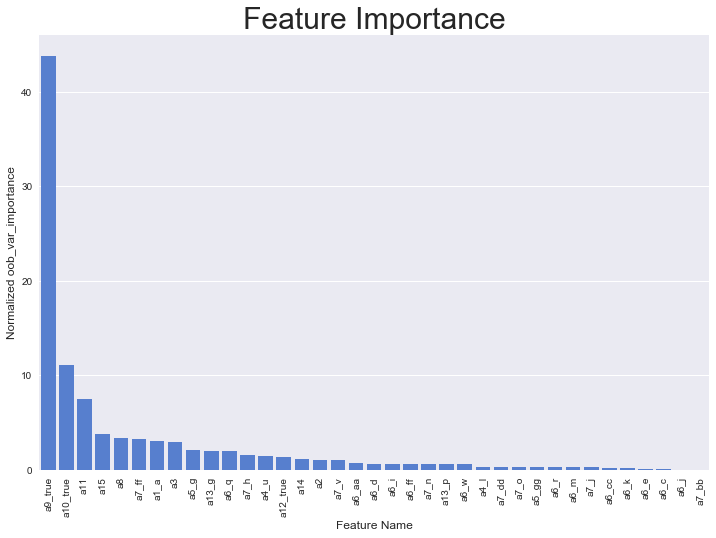

In [47]:
# bar_plot(data,title,x,xLabel,y,yLabel,color=None,xAxisRotation=90)
bar_plot(df_oob_var_imp, 
         'Feature Importance', # title
         'feature', # x
         'Feature Name', # x label
         'oob_var_importance', # y
         'Normalized oob_var_importance', # y label
        "#4378E2") # color

#### Score Test Data

https://madlib.apache.org/docs/latest/group__grp__random__forest.html

In [48]:
%%execsql
DROP TABLE IF EXISTS public.model_test_scored;
SELECT madlib.forest_predict(
    'public.rf_model_output'     -- tree model
    , 'public.model_test'        -- new data table
    , 'public.model_test_scored' -- output table
    , 'prob');                   -- show probability

In [49]:
%%read_sql
select * from model_test_scored limit 10;

Query started at 01:05:33 AM KST; Query executed in 0.00 m

,_id,estimated_prob_0,estimated_prob_1
0,5,0.6,0.4
1,13,0.4,0.6
2,25,0.1,0.9
3,27,0.0,1.0
4,31,0.1,0.9
5,37,0.1,0.9
6,41,0.0,1.0
7,49,1.0,0.0
8,65,0.2,0.8
9,75,1.0,0.0


In [50]:
%%execsql
DROP TABLE IF EXISTS public.model_test_scored_actual;
CREATE TABLE public.model_test_scored_actual AS (
    SELECT a.*
        , CASE WHEN a.estimated_prob_1 >= a.estimated_prob_0 THEN 1 ELSE 0 END AS predicted
        , b.approval
    FROM public.model_test_scored_tmp a
        JOIN public.model_test b 
        USING (_id)
);

In [51]:
%%read_sql
SELECT * FROM model_test_scored_actual LIMIT 10;

Query started at 01:05:33 AM KST; Query executed in 0.00 m

,_id,estimated_prob_0,estimated_prob_1,predicted,approval
0,4,0.1,0.9,1,1
1,66,0.2,0.8,1,1
2,170,1.0,0.0,0,1
3,180,0.1,0.9,1,1
4,267,1.0,0.0,0,0
5,289,1.0,0.0,0,0
6,331,0.4,0.6,1,0
7,359,1.0,0.0,0,0
8,371,0.8,0.2,0,0
9,403,0.9,0.1,0,0


#### View tree in dot format
View a single tree within the forest identified by 'gid' and 'sample_id', out of the several that were created:

In [52]:
pd.set_option('display.max_colwidth', 200)

In [53]:
%%read_sql rf_model_tree
SELECT madlib.get_tree('rf_model_output', 1, 7);

Query started at 01:05:33 AM KST; Query executed in 0.00 m

,get_tree
0,"digraph ""Classification tree for model_train"" {\n""0"" [label=""a3 <= 4"", shape=ellipse];\n""0"" -> ""1""[label=""yes""];\n""0"" -> ""2""[label=""no""];\n""1"" [label=""a9_true <= 0"", shape=ellipse];\n""1"" -> ""3""[la..."


In [54]:
# set paths for your environment
from os.path import expanduser
home = expanduser(MADLIB_PROJECT_PATH)

dot_output = %read_sql select madlib.get_tree('rf_model_output',1,7, TRUE, TRUE);

with open('tree_out.dot', 'w') as f: 
     f.write(dot_output.loc[0][0])  

Query started at 01:05:33 AM KST; Query executed in 0.00 m

In [55]:
print(dot_output.loc[0][0])

digraph "Classification tree for model_train" {
"0" [label="a3 <= 4\n impurity = 0.4995\n samples = 506\n value = [261 245]\n class = 0", shape=ellipse];
"0" -> "1"[label="yes"];
"0" -> "2"[label="no"];
"1" [label="a9_true <= 0\n impurity = 0.46875\n samples = 304\n value = [190 114]\n class = 0", shape=ellipse];
"1" -> "3"[label="yes"];
"1" -> "4"[label="no"];
"2" [label="a4_u <= 0\n impurity = 0.455887\n samples = 202\n value = [ 71 131]\n class = 1", shape=ellipse];
"2" -> "5"[label="yes"];
"2" -> "6"[label="no"];
"3" [label="a6_cc <= 0\n impurity = 0.189757\n samples = 179\n value = [160  19]\n class = 0", shape=ellipse];
"3" -> "7"[label="yes"];
"3" -> "8"[label="no"];
"4" [label="a10_true <= 0\n impurity = 0.3648\n samples = 125\n value = [30 95]\n class = 1", shape=ellipse];
"4" -> "9"[label="yes"];
"4" -> "10"[label="no"];
"5" [label="a7_bb <= 0\n impurity = 0.489796\n samples = 28\n value = [16 12]\n class = 0", shape=ellipse];
"5" -> "11"[label="yes"];
"5" -> "12"[label="no"]

#### Visualize the tree using pygraphviz

True


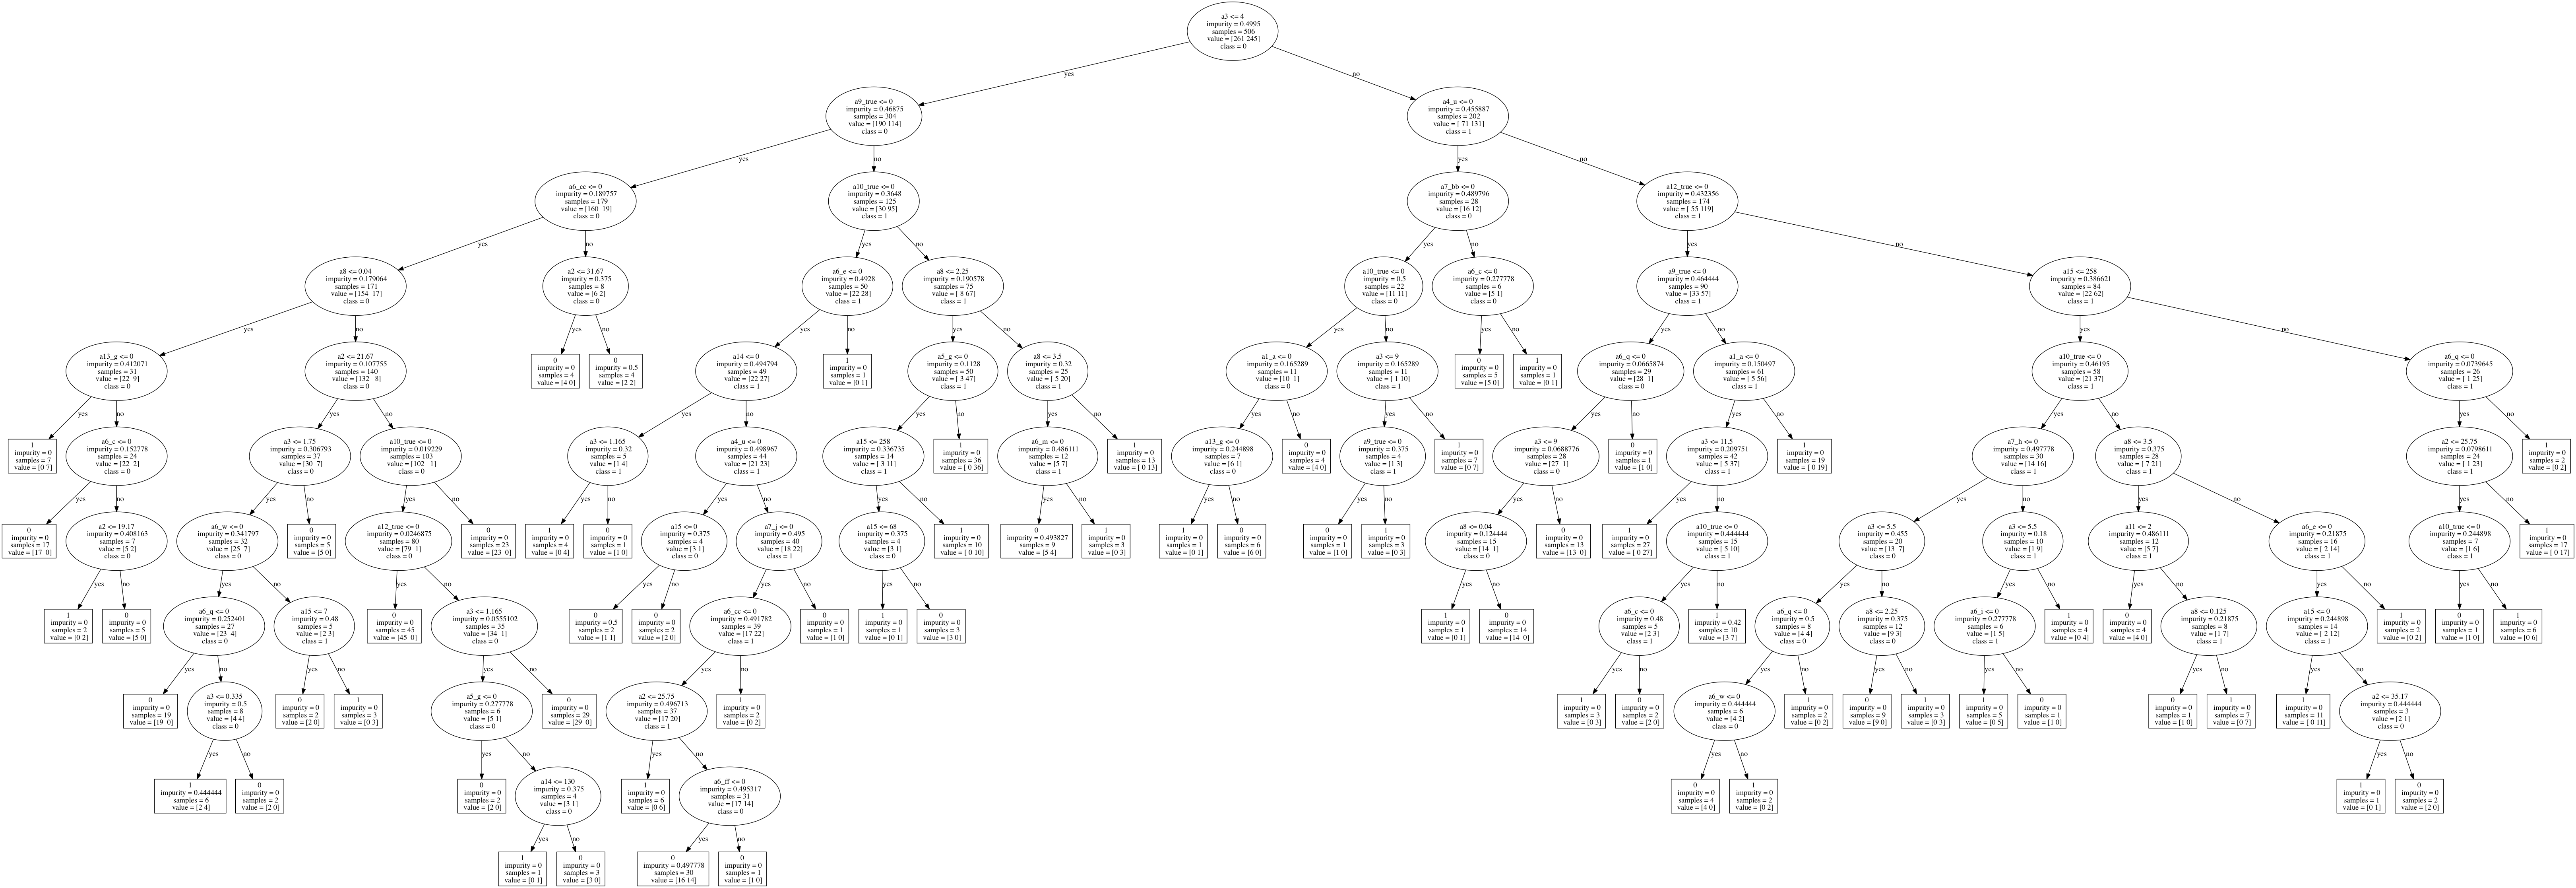

In [56]:
import pygraphviz as pgv
from IPython.display import Image
graph = pgv.AGraph("tree_out.dot")
print bool(graph)
graph.draw('tree_out.png',prog='dot')
Image('tree_out.png')

#### AUC: Area Under ROC(Receiver Operating Characteristic) Curve

https://madlib.apache.org/docs/v1.10/group__grp__pred.html

In [57]:
%%execsql
DROP TABLE IF EXISTS public.model_test_scored_auc;
SELECT madlib.area_under_roc(
    'public.model_test_scored_actual' -- table_in
    , 'public.model_test_scored_auc'  -- table_out
    , 'estimated_prob_1'              -- prediction_col
    , 'approval'                      -- observed_col
)

In [58]:
%read_sql SELECT * FROM public.model_test_scored_auc;

Query started at 01:05:34 AM KST; Query executed in 0.00 m

,area_under_roc
0,0.945853


#### Receiver Operating Characteristic Graph (ROC Curve)

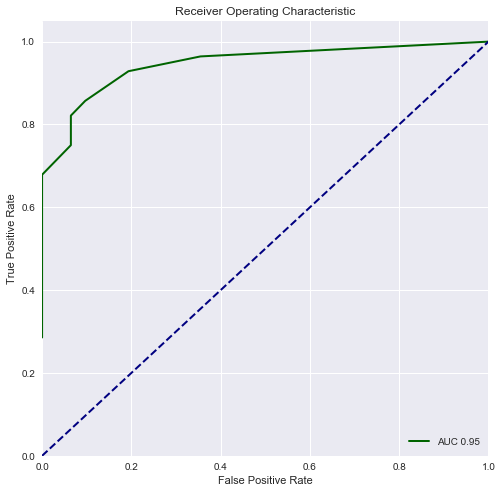

In [59]:
# ROC
query = """
    SELECT * 
    FROM public.model_test_scored_auc;
"""
auc = query_gpdb(query)['area_under_roc'][0]

query = """
    DROP TABLE IF EXISTS public.model_test_scored_roc;
    SELECT madlib.binary_classifier( 
        'public.model_test_scored_actual'
       ,'public.model_test_scored_roc'
       ,'estimated_prob_1'
       ,'approval'
    );
"""
cur.execute(query)

query = """
    SELECT threshold
          ,fpr
          ,tpr
    FROM public.model_test_scored_roc
    ORDER BY 1
"""
df = query_gpdb(query)

# roc curve
pylab.rcParams['figure.figsize'] = (8, 8)

plt.figure()
lw = 2
plt.plot(df['fpr'], df['tpr'], color='darkgreen', lw=lw, label='AUC {:0.2f}'.format(auc))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

**Evaluation of binary classifiers with Confusion Matrix**
- precision = TP/(TP+FP)
- recall, sensitivity, TPR = TP/(TP+FN)
- specificity = TN/(FP+TN)
- accuracy = (TP+TN)/N

*Image source: https://en.wikipedia.org/wiki/Evaluation_of_binary_classifiers*

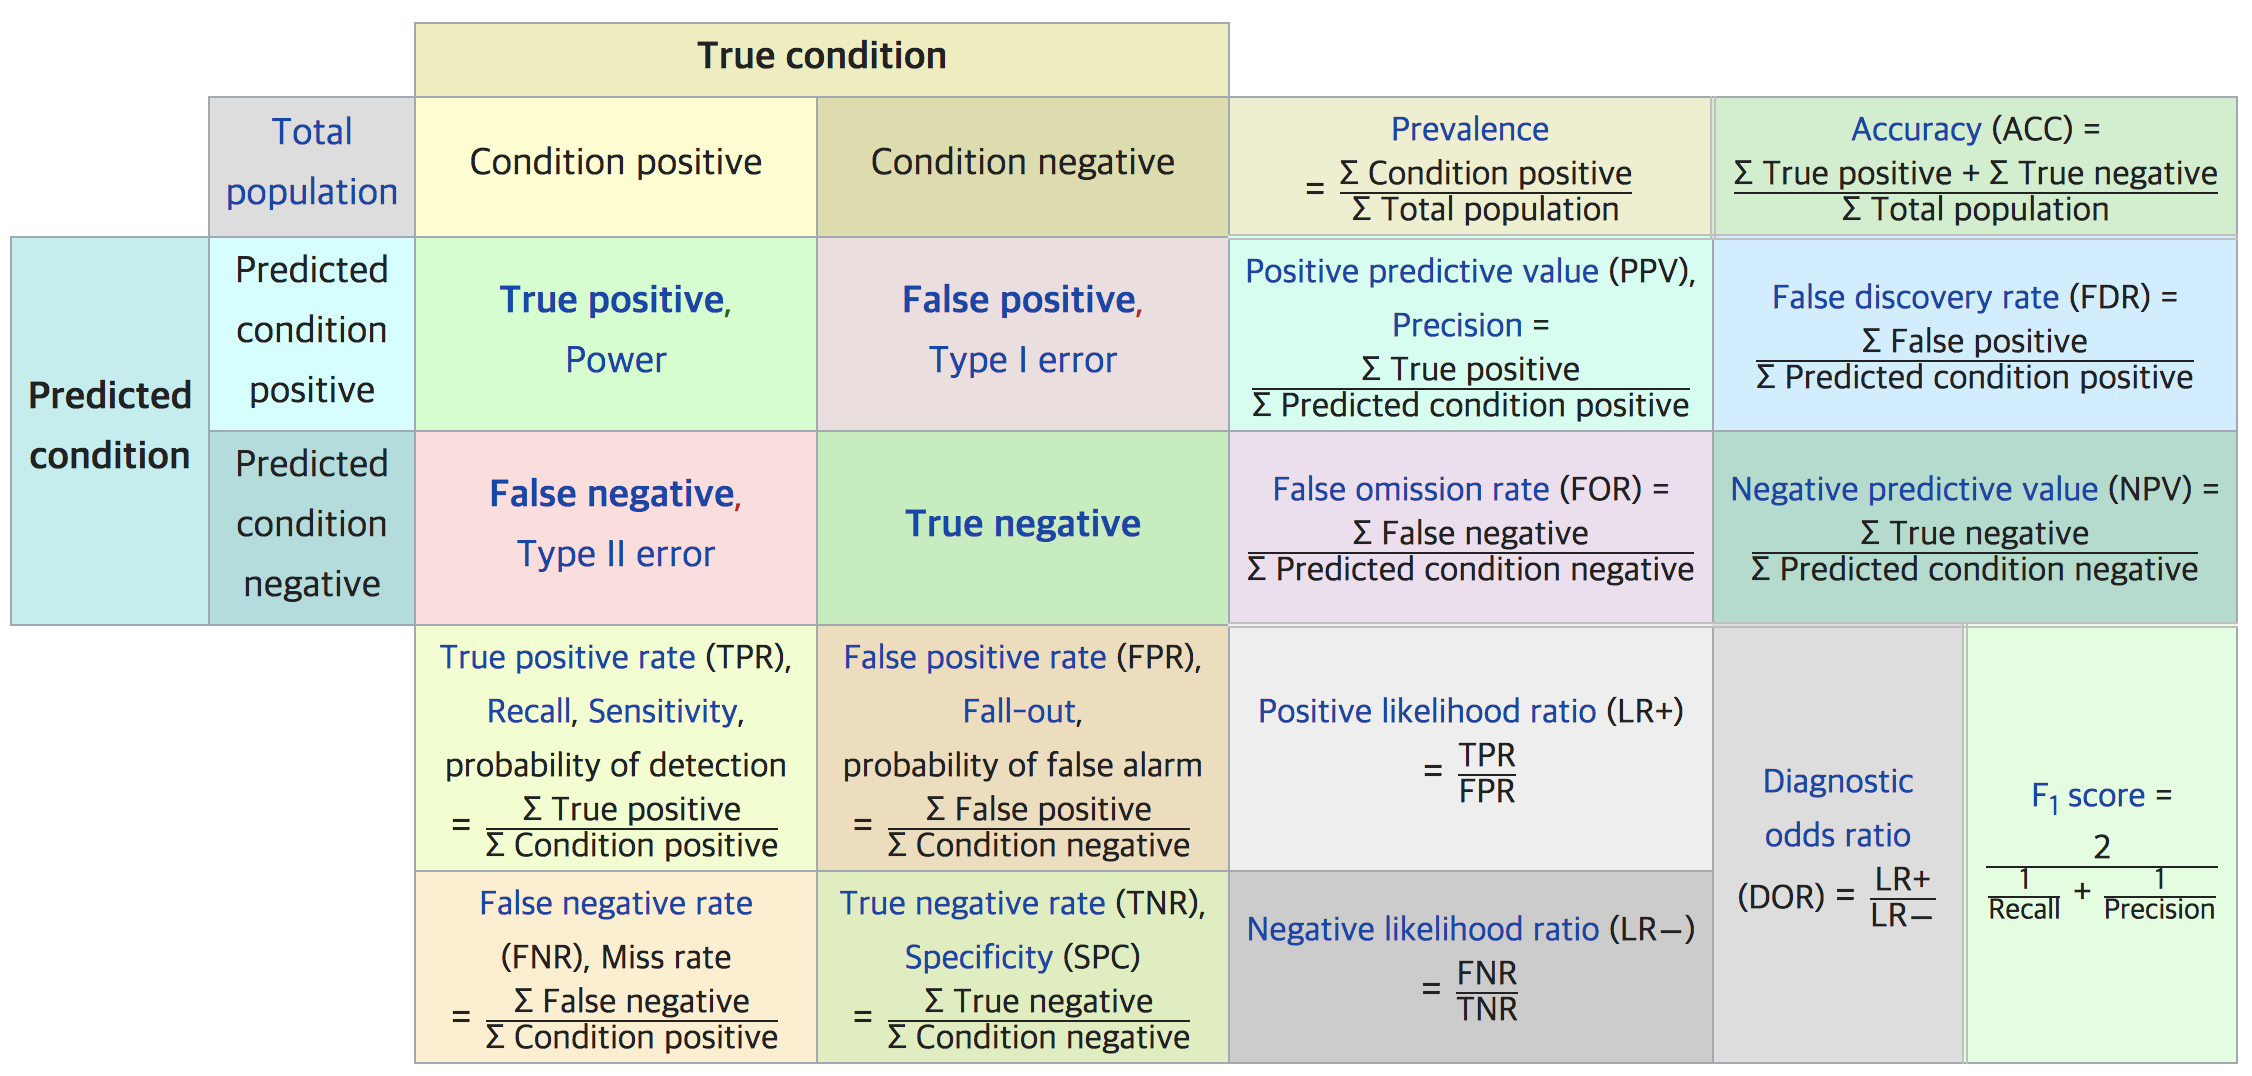

In [60]:
Image(filename=os.path.join(MADLIB_PROJECT_PATH, 'evaluation_of_binary_classifiers.png'))

#### Confusion Matrix

In [61]:
%%read_sql actual_predicted
SELECT approval as actual, predicted, count(*) as cnt 
    FROM model_test_scored_actual
    GROUP BY approval, predicted;

Query started at 01:05:34 AM KST; Query executed in 0.00 m

,actual,predicted,cnt
0,0,1,2
1,1,0,7
2,0,0,29
3,1,1,21


In [62]:
pd.pivot_table(actual_predicted, 
               index='actual', 
               columns='predicted', 
               values='cnt', 
               aggfunc=np.sum, 
               margins=True)

predicted,0,1,All
actual,,,
0,29.0,2.0,31.0
1,7.0,21.0,28.0
All,36.0,23.0,59.0


#### --- The End ---